## OpenPIV tutorial of various correlation types

In this notebook we compare the time to run the same analysis using Cython (precompiled) version
with the Python process using FFT and/or direct cross-correlation method

In [1]:
from openpiv import tools, scaling, pyprocess, validation, filters
import numpy as np
import pylab
%matplotlib inline

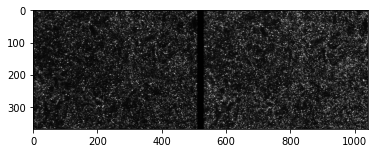

In [2]:
frame_a  = tools.imread( '../test1/exp1_001_a.bmp' )
frame_b  = tools.imread( '../test1/exp1_001_b.bmp' )

pylab.imshow(np.c_[frame_a,np.ones((frame_a.shape[0],20)),frame_b],
             cmap=pylab.cm.gray)



In [3]:
# Typical set of parameters 

window_size = 32 # pixels, IW size in frame A
overlap = 16 # 50% overlap
search_area_size = 32 # pixels, IW in frame B, helps for large displacements
dt = 0.02 # second, 50 Hz, just an example
scaling_factor = 96.52 # micron/pixel

In [4]:
%%time

# default correlation is FFT circular type (faster, less robust)
# default type of correlation is not normalized, faster
# we do not know the values of signal to noise ratio a priori
# therefore we decide that we remove lowest 5%
# the signal to noise ratio is defined here as 1st to 2nd peak ratio
# All the parameters need to be checked. 

# get the values of displacements in pixel/sec units
u, v, sig2noise = pyprocess.extended_search_area_piv( 
    frame_a, frame_b, 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak' )


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'circular_default.txt' )

CPU times: user 122 ms, sys: 8.55 ms, total: 130 ms
Wall time: 129 ms


/home/user/miniconda3/envs/openpiv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/miniconda3/envs/openpiv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
%%time

# use normalized_correlation
# both image intensity is normalized before correlation
# and the correlation map has peaks between 0..1

# get the values of displacements in pixel/sec units
u, v, sig2noise = pyprocess.extended_search_area_piv( 
    frame_a, frame_b, 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak',
    normalized_correlation = True)


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'circular_normalized.txt' )

CPU times: user 136 ms, sys: 7.59 ms, total: 143 ms
Wall time: 143 ms


In [6]:
%%time

# change to another type of correlation 'linear' - uses
# zero padding prior to the correlation
# it requires uniform background and therefore 
# we need to normalize intensity of the images

u, v, sig2noise = pyprocess.extended_search_area_piv( 
    pyprocess.normalize_intensity(frame_a), 
    pyprocess.normalize_intensity(frame_b), 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak',
    correlation_method = 'linear') 


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'linear_intensity.txt' )

CPU times: user 193 ms, sys: 32.3 ms, total: 226 ms
Wall time: 225 ms


In [7]:
%%time

# add normalized correlation to linear

u, v, sig2noise = pyprocess.extended_search_area_piv( 
    pyprocess.normalize_intensity(frame_a), 
    pyprocess.normalize_intensity(frame_b), 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak',
    correlation_method='linear',
    normalized_correlation=True) 


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'linear_normalized.txt' )

CPU times: user 222 ms, sys: 39.3 ms, total: 261 ms
Wall time: 262 ms


In [8]:
%%time


# change to the extended search_type when window size in B is 
# larger to capture large displacements

search_area_size = 40

u, v, sig2noise = pyprocess.extended_search_area_piv( 
    frame_a, 
    frame_b, 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak',
    correlation_method='linear',
    normalized_correlation=True) 


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'linear_normalized_extended.txt' )

CPU times: user 217 ms, sys: 36.3 ms, total: 254 ms
Wall time: 253 ms


In [9]:
%%time

# default correlation is FFT circular type (faster, less robust)
# default type of correlation is not normalized, faster
# we do not know the values of signal to noise ratio a priori
# therefore we decide that we remove lowest 5%
# the signal to noise ratio is defined here as 1st to 2nd peak ratio
# All the parameters need to be checked. 

# get the values of displacements in pixel/sec units
u, v, sig2noise = pyprocess.extended_search_area_piv( 
    frame_a, frame_b, 
    window_size=window_size, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=search_area_size, 
    sig2noise_method='peak2peak' )


# prepare centers of the IWs to know where locate the vectors
x, y = pyprocess.get_coordinates(frame_a.shape, 
                                 search_area_size=search_area_size, 
                                 overlap=overlap)

u, v, mask = validation.sig2noise_val( u, v, 
                                      sig2noise, 
                                      threshold = np.percentile(sig2noise,5))

# removing and filling in the outlier vectors
u, v = filters.replace_outliers( u, v, method='localmean', 
                                max_iter=10, 
                                kernel_size=2)

# rescale the results to millimeters and mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, 
                             scaling_factor=scaling_factor )

# save the data
tools.save(x, y, u, v, sig2noise, mask, 'circular_extended.txt' )

CPU times: user 70.3 ms, sys: 0 ns, total: 70.3 ms
Wall time: 69.8 ms


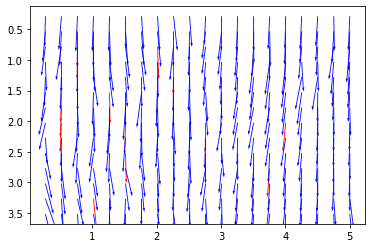

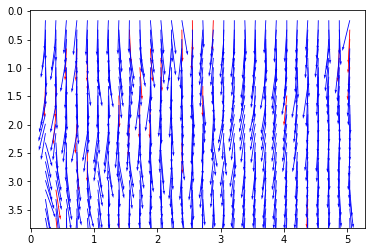

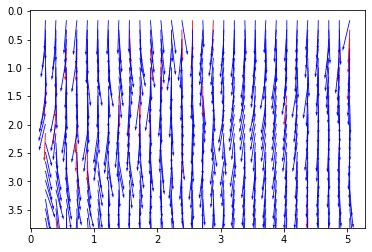

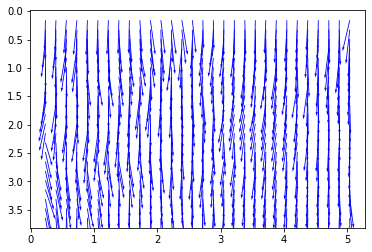

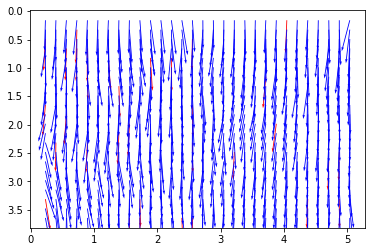

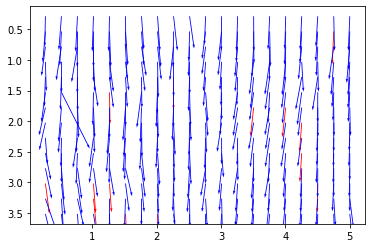

In [10]:
tools.display_vector_field('linear_normalized_extended.txt', scale=30)
tools.display_vector_field('linear_normalized.txt', scale=30)
tools.display_vector_field('linear_intensity.txt', scale=30)
tools.display_vector_field('circular_default.txt', scale=30);
tools.display_vector_field('circular_normalized.txt', scale=30);
tools.display_vector_field('circular_extended.txt', scale=30);